In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_actions):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.fc(x)

def compute_returns(rewards, gamma):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return torch.tensor(returns)

def main():
    env = gym.make("CartPole-v1")
    n_inputs = env.observation_space.shape[0]
    n_actions = env.action_space.n
    policy = PolicyNetwork(n_inputs, n_actions)
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    gamma = 0.99

    for episode in range(100000):
        state,_ = env.reset()
        log_probs = []
        rewards = []

        for steps in range(1000):
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            probs = policy(state_tensor)
            action = np.random.choice(n_actions, p=probs.detach().numpy()[0])
            log_prob = torch.log(probs.squeeze(0)[action])
            state, reward, done,_, _ = env.step(action)

            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break

        returns = compute_returns(rewards, gamma)
        loss = (-torch.stack(log_probs) * returns).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if episode % 50 == 0:
            print(f"Episode: {episode}, Loss: {loss.item()}, Total Reward: {sum(rewards)}")

if __name__ == "__main__":
    main()


In [ ]:
import time
import numpy as np

import editdistance
import matplotlib.pyplot as plt
import torch as th
from scipy.spatial import distance
from scipy.stats import spearmanr

from src.core.dataset import create_concept_dataset


from numba import jit


@jit(nopython=True)
def pdist(X: np.ndarray, metric):
    n = X.shape[0]
    out_size = (n * (n - 1)) // 2
    dm = list(range(out_size))
    k = 0
    for i in range(X.shape[0] - 1):
        for j in range(i + 1, X.shape[0]):
            dm[k] = metric(X[i], X[j])
            k += 1
    return dm


@jit(nopython=True)
def concept_distance(concept1: np.ndarray, concept2: np.ndarray):
    return np.mean(concept1 != concept2)

@jit(nopython=True)
def edit_distance_fast(s1: np.ndarray, s2: np.ndarray):
    if len(s1) < len(s2):
        return edit_distance_fast(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = np.arange(len(s2) + 1, dtype=np.int64)
    for i, c1 in enumerate(s1):
        current_row = np.zeros(len(s2) + 1, dtype=np.int64)
        current_row[0] = i + 1
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row[j + 1] = min(insertions, deletions, substitutions)
        previous_row = current_row

    return previous_row[-1]




def topsim(concept: np.ndarray, language: np.ndarray):
    concept_pdist = pdist(concept, concept_distance)
    language_pdist = pdist(language, edit_distance_fast)
    # language_pdist = pdist(language, editdistance_numba)
    return spearmanr(concept_pdist, language_pdist).correlation


n_attrs = 2
max_len = 10
vocab_size = 50
ls_values = list(range(10, 50, 10))
topsims = []
for n_values in ls_values:
    concepts, _ = create_concept_dataset(n_attrs, n_values).tensors
    messages = th.randint(0, vocab_size, (concepts.shape[0], max_len))

    start = time.time()
    tp = topsim(concepts.numpy(), messages.numpy())
    elapsed = time.time() - start
    print(n_values, tp, elapsed)
    topsims.append(elapsed)


plt.plot(ls_values, topsims)
plt.show()

In [7]:
import numpy as np
import time
from numba import jit


# @jit(nopython=True)
# def fast_rank_array(a: np.ndarray) -> np.ndarray:
#     n = len(a)
#     ivec = np.argsort(a)
#     svec = a[ivec]
#     sumranks = 0
#     dupcount = 0
#     newarray = np.zeros(n)
#     for i in range(n):
#         sumranks += i
#         dupcount += 1
#         if i == n - 1 or svec[i] != svec[i + 1]:
#             averank = sumranks / float(dupcount) + 1
#             for j in range(i - dupcount + 1, i + 1):
#                 newarray[ivec[j]] = averank
#             sumranks = 0
#             dupcount = 0
#     return newarray

@jit(nopython=True)
def fast_rank_array(a: np.ndarray) -> np.ndarray:
    # n = len(a)
    # temp = a.argsort()
    # ranks = np.empty_like(temp)
    # ranks[temp] = np.arange(n)
    # return ranks + 1
    return np.argsort(np.argsort(a)) 



@jit(nopython=True)
def fast_spearmanr(a: np.ndarray, b: np.ndarray) -> float:
    a_rank = fast_rank_array(a)
    b_rank = fast_rank_array(b)
    d = a_rank - b_rank
    rho = 1 - 6 * np.sum(d**2) / (len(a) * (len(a) ** 2 - 1))
    return rho


from scipy.stats import spearmanr

# Generate random data
n = 10000000
a = np.random.rand(n)
b = np.random.rand(n)

# Calculate Spearman's rho using our implementation
start = time.time()
rho_fast = fast_spearmanr(a, b)
elapsed = time.time() - start
print(f"Spearman's rho (fast): {rho_fast}, elapsed: {elapsed}")

# Calculate Spearman's rho using Scipy
start = time.time()
rho_scipy, _ = spearmanr(a, b)
elapsed = time.time() - start
print(f"Spearman's rho (Scipy): {rho_scipy}, elapsed: {elapsed}")

# Verify the results are the same
assert np.isclose(rho_fast, rho_scipy), "The results do not match!"

Spearman's rho (fast): 0.05539586816252007, elapsed: 6.059314012527466
Spearman's rho (Scipy): 0.0002147044148315312, elapsed: 3.2527990341186523


AssertionError: The results do not match!

In [22]:
from enum import Enum


class Color(Enum):
    RED = "red"
    GREEN = "green"
    BLUE = "blue"

    def __str__(self):
        return self.value


def f(red: int, green: int, blue: int):
    return red + green + blue


params = {str(Color.RED): 1, str(Color.GREEN): 2, str(Color.BLUE): 3}

f(**params)

6

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e'}
Graph with 5 nodes and 10 edges


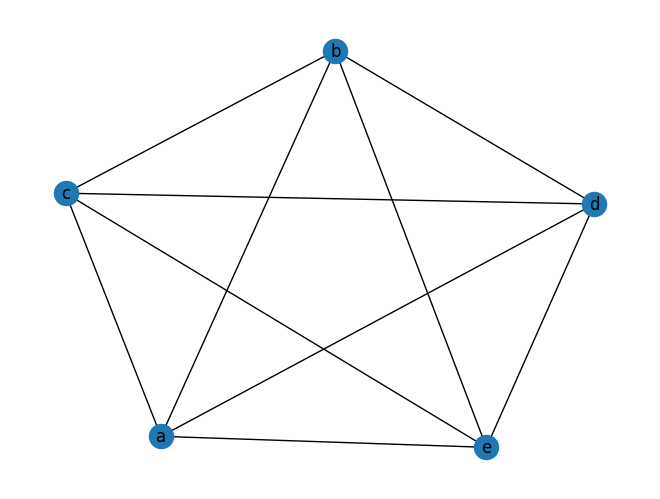

In [44]:
import networkx as nx

agents = ["a", "b", "c", "d", "e"]
# agents = {i: agents[i] for i in range(len(agents))}
agents=dict(enumerate(agents))
print(agents)


g = nx.complete_graph(5)

# render g

g=nx.relabel_nodes(g, agents)
print(g)

# render g
nx.draw(g, with_labels=True)

In [50]:
def f():
    return [1]

q,=f()

print(q)

1
